In [1]:
%pylab inline
import pandas as pd
from analysis_toolbox import *
from qualityBaseline import *
bb_info = pd.read_csv("computed_my_COCO_BBvals.csv",index_col=0)
bb_info = bb_info.fillna(0)

Populating the interactive namespace from numpy and matplotlib


We are interested in how whether the $D_i$ and $q_j$ for our data agrees with our equations : 
    $$D_i = \sum_{j\in J_i} dist(\phi_j,\phi_i)$$
    $$q_{ij} = dist(\phi_{ij},\phi_i)$$

# Task difficulty(D_i)

This just boils down to :

$D_i = \sum 1-\phi_i$

for most of the metrics that compare against ground truth. Num Points, Area ratio excluded. 

Everything that is annotated by worker_id =3 is drawn by me 

In [2]:
metrics_lst = ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',"NME [COCO]","Num Points",\
               'Precision [Self]','Recall [Self]','Jaccard [Self]',"NME [Self]","Area Ratio"]

In [4]:
di_oid_lst = []
for oid in list(set(bb_info.object_id)):
#     print 'oid:',oid
    di_lst = []
    object_bbs = bb_info[bb_info["object_id"]==oid]
#     print object_bbs
    for metric in metrics_lst: 
        if metric in ["Num Points", "Area Ratio"]:
            try:
                phi_i = float(object_bbs[object_bbs["worker_id"]==3][metric])
            except(TypeError):
                # some objects don't have worker 3 annotations [this is resolved now]
                print "oid bad"
                pass
        else: 
            phi_i =1
        # Distance calculation (if more than 1d than do something more complicated that subtraction.)
        phi_j = object_bbs[metric]
#         print phi_i
        di = abs(phi_i-phi_j)
        di_lst.append(di)
    di_oid_lst.append([oid,sum(di_lst)])

In [5]:
dtbl = pd.DataFrame(di_oid_lst,columns=["object id","task difficulty"])

We can conduct separate analysis based on 3  different errors

In [6]:
task_ambiguity = [1,4,8,10,18,20,22,27,28,29,30,31,32,33,35,40,42]
small_area = [1,15,22]
high_numPts=[5,7,9,10,11,12,28,29,30,37]

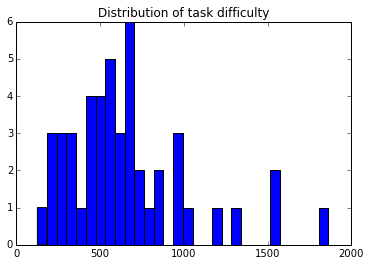

In [7]:
plt.hist(dtbl["task difficulty"],bins=30)
plt.title("Distribution of task difficulty")

In [8]:
task_ambiguity_tbl = dtbl[dtbl["object id"].isin(task_ambiguity)]
small_area_tbl = dtbl[dtbl["object id"].isin(small_area)]
high_numPts_tbl = dtbl[dtbl["object id"].isin(high_numPts)]

In [9]:
all_hard_tasks = list(set(np.concatenate((task_ambiguity,small_area,high_numPts))))

In [10]:
easy_tbl  = dtbl[~dtbl["object id"].isin(all_hard_tasks)]

The overall difficulty is lower compared to the ones that are prone to error, so this indicates that our Di does capture these difficulty measures. 

In [11]:
print dtbl["task difficulty"].mean()
print task_ambiguity_tbl["task difficulty"].mean()
print small_area_tbl["task difficulty"].mean()
print high_numPts_tbl["task difficulty"].mean()
print easy_tbl["task difficulty"].mean()

655.523569743
903.956897424
852.850284908
673.955026449
565.955266073


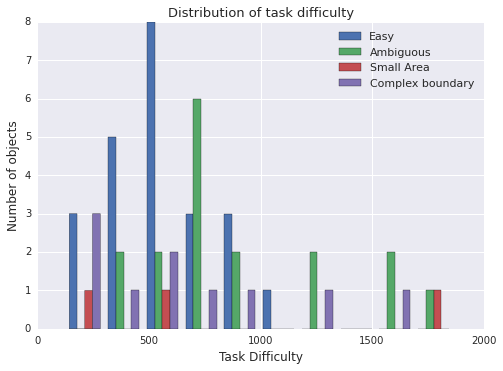

In [592]:
# import seaborn
data = [easy_tbl["task difficulty"].values,task_ambiguity_tbl["task difficulty"].values,\
         small_area_tbl["task difficulty"].values,high_numPts_tbl["task difficulty"].values]
s = plt.hist(data, 10, histtype='bar',label=["Easy","Ambiguous","Small Area",'Complex boundary'])
plt.title("Distribution of task difficulty",fontsize=13)
plt.legend(fontsize=11)
plt.xlabel("Task Difficulty",fontsize=12)
plt.ylabel("Number of objects",fontsize=12)
plt.savefig("difficulty_histo.pdf")

It makes more sense to see the normalized histogram because there are different numbers of objects in each category so it is hard to compare the raw counts. But again this is a bit biased since there are only a small number of tasks, for example there are only 3 small area tasks.

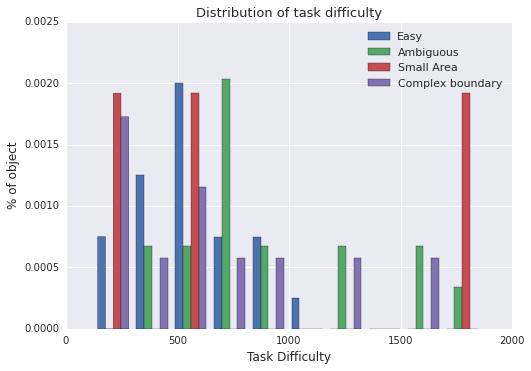

In [108]:
data = [easy_tbl["task difficulty"].values,task_ambiguity_tbl["task difficulty"].values,\
         small_area_tbl["task difficulty"].values,high_numPts_tbl["task difficulty"].values]
s = plt.hist(data, 10, histtype='bar',label=["Easy","Ambiguous","Small Area",'Complex boundary'],normed=True)
plt.title("Distribution of task difficulty",fontsize=13)
plt.legend(fontsize=11)
plt.xlabel("Task Difficulty",fontsize=12)
plt.ylabel("% of object",fontsize=12)

In [12]:
avrg_d = [["Overall",dtbl["task difficulty"].mean()],\
         ["Ambiguous",task_ambiguity_tbl["task difficulty"].mean()],\
         ["Small area",small_area_tbl["task difficulty"].mean()],\
         ["Complex boundary",high_numPts_tbl["task difficulty"].mean()],\
         ["Easy", easy_tbl["task difficulty"].mean()]]

In [13]:
print tabulate(avrg_d,headers=['','Avrg task difficulty'],tablefmt='latex',floatfmt='.2f')

\begin{tabular}{lr}
\hline
                  &   Avrg task difficulty \\
\hline
 Overall          &                 655.52 \\
 Ambiguous        &                 903.96 \\
 Small area       &                 852.85 \\
 Complex boundary &                 673.96 \\
 Easy             &                 565.96 \\
\hline
\end{tabular}


The easy tasks are ones that are neither in any of the error-prone categories, they have the lowest average difficulties. Then, of all the error categories, ambiguous tasks makes the task most difficult, followed by hard-to-annotated tasks due to small area and complex boundaries.

In [14]:
# bins = numpy.linspace(dtbl["task difficulty"].min(), dtbl["task difficulty"].max(), 30)
# plt.hist(dtbl["task difficulty"].values,bins,label="Overall",alpha=0.1)
# plt.hist(task_ambiguity_tbl["task difficulty"].values,bins,label="Ambiguous Task Description",alpha=0.5)
# plt.hist(small_area_tbl["task difficulty"].values,bins,label="Small Area",alpha=0.7)
# plt.hist(high_numPts_tbl["task difficulty"].values,label="Complex boundary",alpha=0.7)
# plt.title("Distribution of task difficulty")
# plt.legend(fontsize=9)

# Worker qualities (q_j)

$$q_{ij} = dist(\phi_{ij},\phi_i)$$

In [15]:
worker_id_lst = list(set(bb_info.worker_id))
di_oid_lst = []
# for oid in list(set(bb_info.object_id)):
for wid in tqdm([x for x in list(set(bb_info.worker_id)) if x!=3]):
    worker_bbs = bb_info[bb_info["worker_id"]==wid]
    for metric in metrics_lst: 
        di_lst = []
        for oid in range(1,48):
            object_bbs = worker_bbs[worker_bbs["object_id"]==oid]
            if (not object_bbs.empty):

                    if metric in ["Num Points", "Area Ratio"]:
                        try:
                            phi_i = float(bb_info[bb_info["worker_id"]==3][bb_info["object_id"]==oid][metric])
                        except(TypeError):
                            # some objects don't have worker 3 annotations [this is resolved now]
                            print "oid bad"
                            print bb_info[bb_info["worker_id"]==3][metric]
                            pass
                    else: 
                        phi_i =1
                    # Distance calculation (if more than 1d than do something more complicated that subtraction.)

                    phi_j = float(object_bbs[metric])
#                     print phi_j
            #         print phi_i
                    di = abs(phi_i-phi_j)
                    di_lst.append(di)
            else:
                di_lst.append(-1)
        di_oid_lst.append([wid,metric]+di_lst)#np.concatenate(([wid,metric],di_lst)))

  0%|          | 0/201 [00:00<?, ?it/s]/Users/dorislee/.virtualenvs/py27dev/lib/python2.7/site-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [16]:
col_names = np.concatenate((['worker id','metric'],['Task '+str(i) for i in range(1,48)]))
worker_quality_tbl = pd.DataFrame(di_oid_lst,columns=col_names)
worker_quality_arr = np.array(di_oid_lst)[:,2:].astype(np.float)
worker_quality_tbl.replace(-1.0,np.nan, inplace=True)
task_only_tbl = worker_quality_tbl[['Task '+str(i) for i in range(1,48)]]

Checked that the number of nonzero entry approximately agrees with the number of BB that we have in the data  times thenumber of different metrics that we have. (the difference is due  to the fact that we excluded worker_id=3 [SELF] in the analysis) 

In [17]:
len(np.where(worker_quality_arr!=-1)[0])

19040

In [18]:
shape(bb_info)[0]*len(metric)

19510

Sum up annotations per person, and plot the annotations per worker to see whether they are bad quality or not 

In [19]:
worker_quality_tbl["sum_i(q_i)"]=task_only_tbl.sum(axis=1,skipna=True)

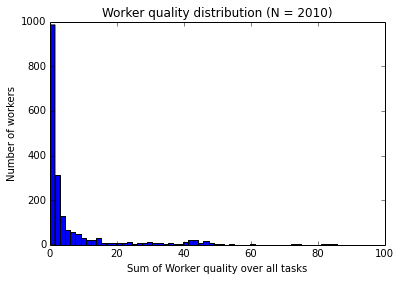

In [78]:
plt.hist(worker_quality_tbl["sum_i(q_i)"],bins=500,normed=1)
plt.title("Worker quality distribution (N = {})".format(len(worker_quality_tbl["sum_i(q_i)"])))
plt.xlabel("Sum of Worker quality over all tasks")
plt.ylabel("Number of workers")
plt.xlim(0,100)

I should really be looking at the averages because this is confounded by the number of task accomplished by each worker

In [27]:
# numNonTaskCol=len([col for col in worker_quality_tbl.columns if col not in ['Task '+str(i) for i in range(1,48)]])
taskPerWorker = task_only_tbl.count(axis=1)
worker_quality_tbl["Num Tasks"]=taskPerWorker
print "average task per worker is : ", mean(taskPerWorker)

average task per worker is :  9.47263681592


In [28]:
worker_quality_tbl["mean_i(q_i)"]=task_only_tbl.mean(axis=1,skipna=True)
print "average worker quality : ", np.mean(worker_quality_tbl["mean_i(q_i)"])

average worker quality :  1.56973468368


In [29]:
exclude = ["worker id","Num Tasks","mean_i(q_i)","sum_i(q_i)"]

(0, 20)

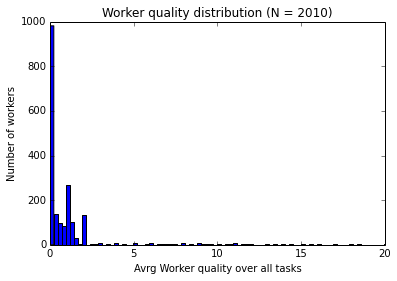

In [124]:
plt.hist(worker_quality_tbl["mean_i(q_i)"],bins=500)
plt.title("Worker quality distribution (N = {})".format(len(worker_quality_tbl["sum_i(q_i)"])))
plt.xlabel("Avrg Worker quality over all tasks")
plt.ylabel("Number of workers")
plt.xlim(0,20)

##### Visualize what someone with really bad quality's annotation is like, ditto for high quality worker


In [31]:
worker_quality_tbl[worker_quality_tbl["mean_i(q_i)"]==worker_quality_tbl["mean_i(q_i)"].min()].dropna(axis=1)

,worker id,metric,sum_i(q_i),Num Tasks,mean_i(q_i)
94,13,Num Points,0,1,0
314,45,Num Points,0,1,0
404,57,Num Points,0,1,0
734,108,Num Points,0,1,0
741,109,Recall [COCO],0,2,0
746,109,Recall [Self],0,2,0
1224,178,Num Points,0,1,0
1225,178,Precision [Self],0,1,0
1274,185,Num Points,0,1,0
1731,242,Recall [COCO],0,1,0


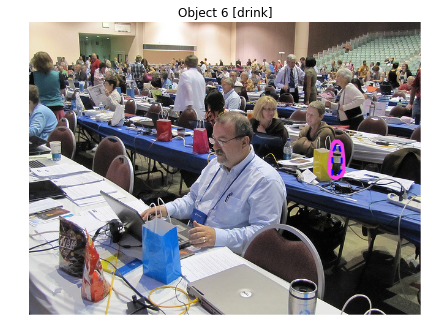

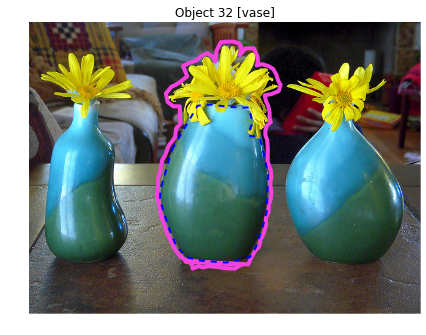

In [154]:
visualize_bb_worker(109,gtypes=['worker','self'])

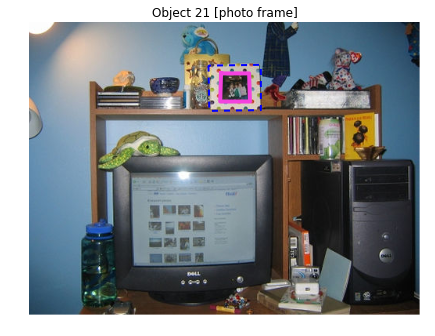

In [157]:
visualize_bb_worker(178,gtypes=['worker','self'])

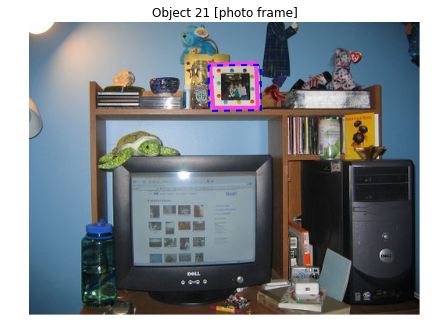

In [32]:
visualize_bb_worker(13,gtypes=['worker','self'])

yes indeed these are very good annotations, note that the blue dotted is the self ground truth and the 

Now lets look at the bad annotations : 

In [33]:
worker_quality_tbl[worker_quality_tbl["mean_i(q_i)"]==worker_quality_tbl["mean_i(q_i)"].max()].dropna(axis=1)

,worker id,metric,Task 30,sum_i(q_i),Num Tasks,mean_i(q_i)
1064,152,Num Points,119,119,1,119


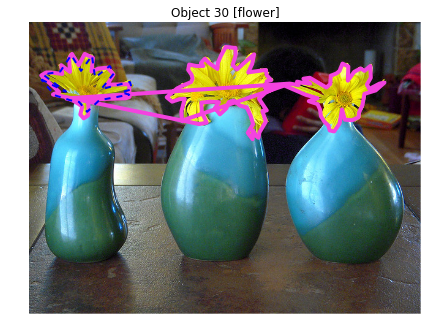

In [34]:
visualize_bb_worker(152,gtypes=['worker','self'])

In [35]:
worker_quality_tbl[worker_quality_tbl["mean_i(q_i)"]>0.96][worker_quality_tbl["metric"]=='Precision [Self]']

,worker id,metric,Task 1,Task 2,Task 3,Task 4,Task 5,Task 6,Task 7,Task 8,...,Task 41,Task 42,Task 43,Task 44,Task 45,Task 46,Task 47,sum_i(q_i),Num Tasks,mean_i(q_i)
185,24,Precision [Self],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1,1.000000
225,31,Precision [Self],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.192546,1,1.192546
395,56,Precision [Self],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1,1.000000
435,61,Precision [Self],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,2,1.000000
855,126,Precision [Self],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1.000000,1,1.000000


These workers draw bad bounding boxes in general, for example, worker 61 just drew wrong bounding boxes for all wrong objects repetitively

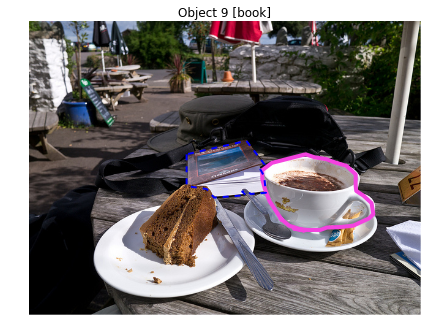

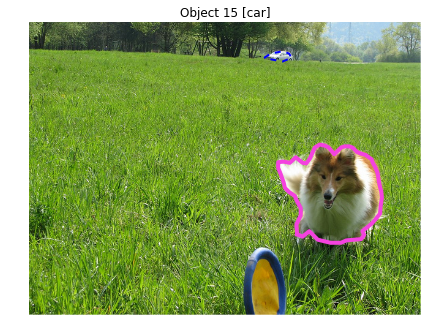

In [36]:
visualize_bb_worker(61,gtypes=['worker','self'])

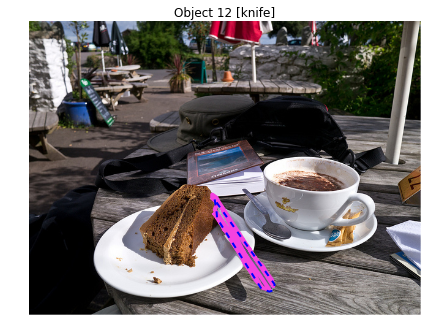

In [37]:
visualize_bb_worker(31,gtypes=['worker','self'])

this is only based on one metric, I really should have looked at it using groupby combining all metric, but this is just a heuristic check so it should be fine 

##### What do most people's distribution of work quality per task look like, are they consistently bad workers? or are they sometimes bad and sometimes good depending on the task at hand. 

standard deviation within each metric 

In [38]:
worker_quality_tbl["std_i(q_i)"]=np.nanstd(task_only_tbl.values,axis=1)
print "average worker quality : ", np.mean(worker_quality_tbl["std_i(q_i)"])

average worker quality :  0.892866926567


In [39]:
worker_quality_tbl.groupby('metric')["std_i(q_i)"].mean()

metric
Area Ratio          0.022572
Jaccard [COCO]      0.513224
Jaccard [Self]      0.124145
NME [COCO]          0.561132
NME [Self]          0.255154
Num Points          6.179227
Precision [COCO]    0.532615
Precision [Self]    0.117459
Recall [COCO]       0.537700
Recall [Self]       0.085440
Name: std_i(q_i), dtype: float64

In [40]:
nonzerostd=[x for x in worker_quality_tbl["std_i(q_i)"].values if x!=0]

In [43]:
np.percentile(nonzerostd,50)
np.percentile(nonzerostd,75)

0.93256502270528174

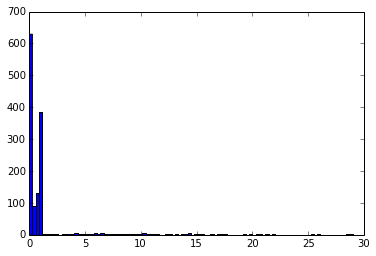

In [44]:
a = plt.hist(nonzerostd,bins=100)

~~The users who takes on more tasks achieves better average quality scores~~

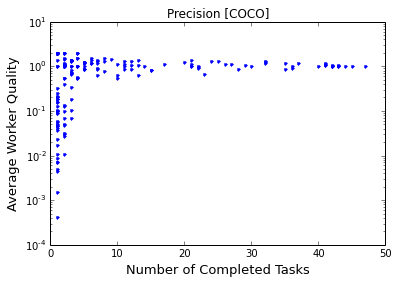

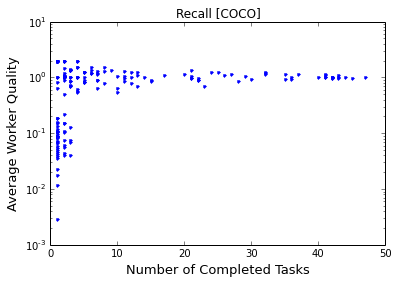

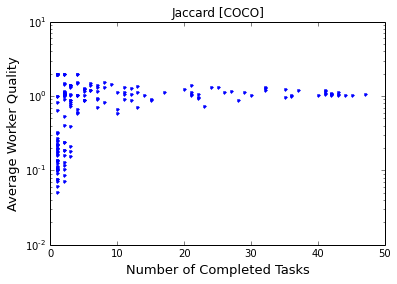

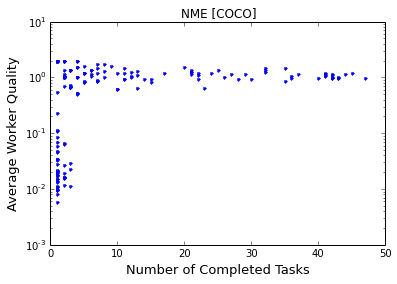

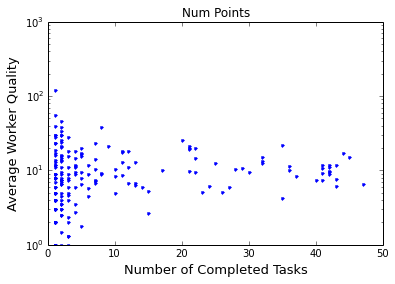

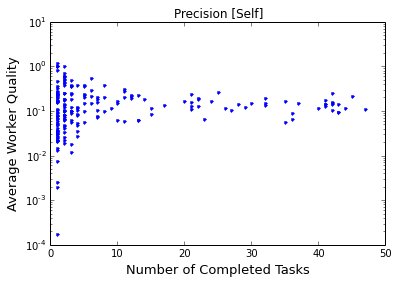

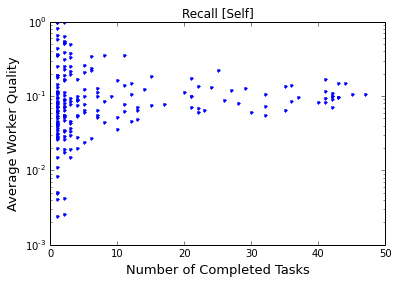

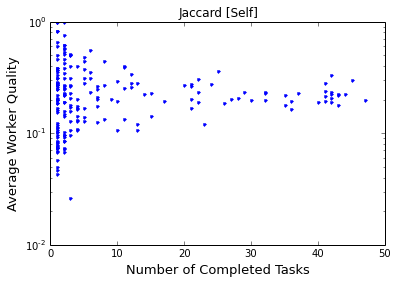

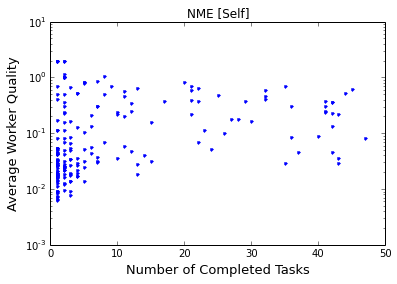

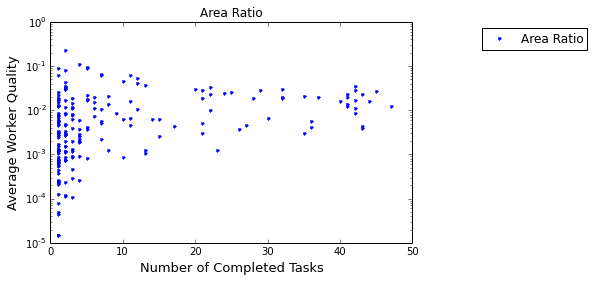

In [61]:
for metric in metrics_lst:
    filtered_tbl = worker_quality_tbl[worker_quality_tbl["metric"]==metric]
    plt.figure()
    plt.title(metric)
    plt.xlabel("Number of Completed Tasks",fontsize=13)
    plt.ylabel("Average Worker Quality",fontsize=13)
    plt.semilogy(filtered_tbl["Num Tasks"].values,filtered_tbl["mean_i(q_i)"].values,'.',label=metric)
    
lgd = plt.legend(numpoints=1, bbox_to_anchor=(1.5, 1))

plt.tight_layout()
plt.savefig('quality_vs_quantity.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

Fitting against distributions

In [145]:
df_stats_tbl = fit_against_all_dist(worker_quality_tbl["mean_i(q_i)"].values,binsize=500)
# Top 5 distributions 
df_stats_tbl.sort(columns=["RSS"])[:5]

,Function Name,Parameters,RSS
72,t,"(0.525716189573, 0.0860355951014, 0.117248158977)",0.379310
58,nct,"(0.533071108476, 28.619087001, -0.040263506288...",0.379925
40,invgauss,"(13.4276521189, -0.0216827080408, 0.11851810947)",0.390218
39,invgamma,"(0.563197908198, -0.0221572652015, 0.062866869...",0.394214
30,genpareto,"(1.36805264943, -1.8151450542e-10, 0.212021542...",0.454683


In [146]:
best_fit = df_stats_tbl[df_stats_tbl["RSS"]==df_stats_tbl["RSS"].min()]

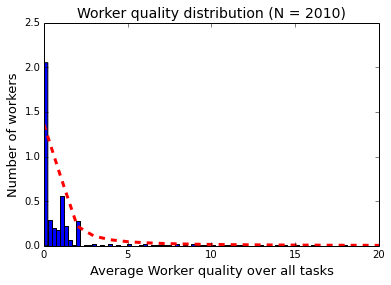

In [160]:
plt.hist(worker_quality_tbl["mean_i(q_i)"],bins=500,normed=1)
plt.title("Worker quality distribution (N = {})".format(len(worker_quality_tbl["mean_i(q_i)"])),fontsize=14)
plt.xlabel("Average Worker quality over all tasks",fontsize=13)
plt.ylabel("Number of workers",fontsize=13)
y= scipy.stats.t.pdf(np.linspace(0,worker_quality_tbl["mean_i(q_i)"].max(),500),0.52571618957301691, 0.086035595101407999, 0.11724815897742302)
plt.plot(y,'--',color='red',linewidth=3)
plt.xlim(0,20)
plt.savefig("Wqual_dist.pdf")